# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 30000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (30000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(28072, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

93.57333333333332

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(28072, 10)


1    23606
0     4466
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
When I ordered these, I thought they were a bit pricey, but I decided to give them a try anyway.  I'm glad I did!  My dogs absolutely love these dried liver treats.  And, since my dogs are all small, I can cut the treats in half and still have large enough pieces to satisfy them. They're great for training; I'll definitely order them again, and would recommend them to anyone.
This was my favorite stevia product and I had it on subscribe and save until I queried customer service about NuNaturals GMO use.  Yes, NuNaturals uses GMO products.  SO, I've canceled my subscribe and save order and am now using <a href="http://www.amazon.com/gp/product/B001ELL3U0">Stevita Stevia Clear Liquid Extract, 3.3-Ounce Container (Pack of 3)</a>.
TOTALLY ORGASMIC.  these chips are the best spicy chip i have ever tasted.  signed up for the subscribe and save

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
When I ordered these, I thought they were a bit pricey, but I decided to give them a try anyway.  I'm glad I did!  My dogs absolutely love these dried liver treats.  And, since my dogs are all small, I can cut the treats in half and still have large enough pieces to satisfy them. They're great for training; I'll definitely order them again, and would recommend them to anyone.
This was my favorite stevia product and I had it on subscribe and save until I queried customer service about NuNaturals GMO use.  Yes, NuNaturals uses GMO products.  SO, I've canceled my subscribe and save order and am now using Stevita Stevia Clear Liquid Extract, 3.3-Ounce Container (Pack of 3).
TOTALLY ORGASMIC.  these chips are the best spicy chip i have ever tasted.  signed up for the subscribe and save option.  the case contained 15(FIFTEEN, FULL SIZED BAGS) 

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This was my favorite stevia product and I had it on subscribe and save until I queried customer service about NuNaturals GMO use.  Yes, NuNaturals uses GMO products.  SO, I have canceled my subscribe and save order and am now using <a href="http://www.amazon.com/gp/product/B001ELL3U0">Stevita Stevia Clear Liquid Extract, 3.3-Ounce Container (Pack of 3)</a>.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This was my favorite stevia product and I had it on subscribe and save until I queried customer service about NuNaturals GMO use Yes NuNaturals uses GMO products SO I have canceled my subscribe and save order and am now using a href http www amazon com gp product B001ELL3U0 Stevita Stevia Clear Liquid Extract 3 3 Ounce Container Pack of 3 a 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 28072/28072 [00:08<00:00, 3470.64it/s]


In [23]:
preprocessed_reviews[1500]

'favorite stevia product subscribe save queried customer service nunaturals gmo use yes nunaturals uses gmo products canceled subscribe save order using'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaand', 'aaah', 'aadp', 'aafco', 'aah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (28072, 30623)
the number of unique words  30623


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (28072, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able drink', 'able eat', 'able enjoy', 'able find', 'able get', 'able give', 'able make']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (28072, 16784)
the number of unique words including both unigrams and bigrams  16784


## [4.4] Word2Vec

In [28]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need
def w2v_fit(preprocessed_reviews):
    i=0
    list_of_sentance=[]
    for sentance in preprocessed_reviews:
        list_of_sentance.append(sentance.split())

    is_your_ram_gt_16g=False
    want_to_use_google_w2v = False
    want_to_train_w2v = True

    if want_to_train_w2v:
        # min_count = 5 considers only words that occured atleast 5 times
        w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
        print(w2v_model.wv.most_similar('great'))
        print('='*50)
        print(w2v_model.wv.most_similar('worst'))

    elif want_to_use_google_w2v and is_your_ram_gt_16g:
        if os.path.isfile('GoogleNews-vectors-negative300.bin'):
            w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
            print(w2v_model.wv.most_similar('great'))
            print(w2v_model.wv.most_similar('worst'))
        else:
            print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")
    return w2v_model

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [29]:
# average Word2Vec
# compute average word2vec for each review.
def avg_w2v_transform(w2v_model,list_of_sentence):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    #w2v_model = word2Vec(list_of_sentence)
    w2v_words = list(w2v_model.wv.vocab)
    for sent in tqdm(list_of_sentence): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        word_len = 0;
        for word in sent.split(): # for each word in a review/sentence
            if word in w2v_words:
                word_len += 1
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vec = sent_vec.tolist()
        #adding review length feature
        sent_vec.append(word_len) 
        sent_vectors.append(sent_vec)
    return np.array(sent_vectors)

#### [4.4.1.2] TFIDF weighted W2v

In [30]:
def tf_idf_transform(model,w_model,list_of_sentence):
    # TF-IDF weighted Word2Vec
    dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
    tfidf_feat = model.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
    w2v_words = list(w_model.wv.vocab)
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sentence): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent.split(): # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

# [4] Featurization

# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [43]:
# Please write all the code with proper documentation
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
from scipy import sparse


X_1, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)


print(y_test.value_counts())

def review_len(review):
    reviews_len =[]
    for sent in review:
        reviews_len.append(len(sent.split()))
    return np.array(reviews_len)

count_vect = CountVectorizer(min_df=5) 
count_vect.fit(X_tr)
test_vect = count_vect.transform(X_test)
cv_vect = count_vect.transform(X_cv)
train_vect = count_vect.transform(X_tr)

len_arr = review_len(X_test)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
test_vect = sparse.hstack((test_vect,len_arr[:,None])).A

len_arr = review_len(X_tr)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
train_vect = sparse.hstack((train_vect,len_arr[:,None])).A

len_arr = review_len(X_cv)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
cv_vect = sparse.hstack((cv_vect,len_arr[:,None])).A

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
scaler.fit(test_vect)  
train_vect = scaler.transform(train_vect)
test_vect = scaler.transform(test_vect)
cv_vect = scaler.transform(cv_vect)


print("After vectorizations")
print(train_vect.shape, y_tr.shape)
print(cv_vect.shape, y_cv.shape)
print(test_vect.shape, y_test.shape)
print("="*100)

1    7081
0    1341
Name: Score, dtype: int64


/Users/ravishankar/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ravishankar/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ravishankar/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


After vectorizations
(13755, 6621) (13755,)
(5895, 6621) (5895,)
(8422, 6621) (8422,)


/Users/ravishankar/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [44]:
train_auc = []
cv_auc = []
alpha_values = [0.0001,0.001,0.01,0.1,1,10,100,1000]
#K_values = [1].append(K_values)
for i in tqdm(alpha_values):
    #svm = SVC(c=i,kernel='linear')
    model=SGDClassifier(alpha=i,loss='hinge')
    svm=CalibratedClassifierCV(model, cv=2)
    svm.fit(train_vect, y_tr)
    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    cv_pred = svm.predict_proba(cv_vect)
    cv_pred = cv_pred[:,1]
    train_pred = svm.predict_proba(train_vect)
    #train_pred = train_pred[:].max(axis=1)
    train_pred = train_pred[:,1]
    #print(train_pred,"------",cv_pred)
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
    train_auc.append(roc_auc_score(y_tr,train_pred))
    cv_auc.append(roc_auc_score(y_cv,cv_pred))
    

    

100%|██████████| 8/8 [00:14<00:00,  1.93s/it]


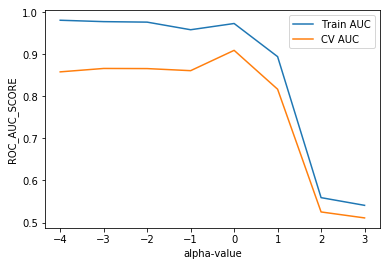

Best alpha-Value 1


In [45]:
plt.plot(np.log10(alpha_values), train_auc, label='Train AUC')
plt.plot(np.log10(alpha_values), cv_auc, label='CV AUC')
plt.xlabel('alpha-value')
plt.ylabel('ROC_AUC_SCORE')
plt.legend()
plt.show()  
print("Best alpha-Value", alpha_values[cv_auc.index(max(cv_auc))])

test_auc 0.9030482577179524


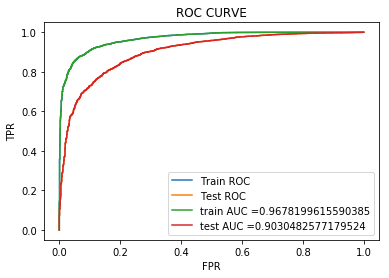

In [46]:

model=SGDClassifier(alpha=alpha_values[cv_auc.index(max(cv_auc))],loss='hinge')
best_svm=CalibratedClassifierCV(model, cv=2)

best_svm.fit(train_vect, y_tr)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
train_pred = best_svm.predict_proba(train_vect)
train_pred = train_pred[:,1]
#print(np.unique(train_pred))
tr_fpr, tr_tpr, tr_thresh = roc_curve(y_tr, train_pred)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
test_pred = best_svm.predict_proba(test_vect)
test_pred = test_pred[:,1]
#print(np.unique(test_pred))
test_fpr, test_tpr, test_thresh = roc_curve(y_test, test_pred)
auc_bow_l = auc(test_fpr,test_tpr)
print("test_auc",auc_bow_l)
plt.plot(tr_fpr, tr_tpr, label="Train ROC")
plt.plot(test_fpr, test_tpr, label="Test ROC")
plt.plot(tr_fpr, tr_tpr, label="train AUC ="+str(auc(tr_fpr, tr_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.legend()
plt.show()

In [47]:
from sklearn.metrics import confusion_matrix
test_pred_class = best_svm.predict(test_vect)
#a = np.unique(test_pred_class)
#print(a)
#print(test_vect.shape)
#print(test_pred_class.shape)
print("Confusion Matrix \n")

C = confusion_matrix(y_test,test_pred_class)
print(C)

accuracy_bow_l = best_svm.score(test_vect, y_test)
print("Test accuracy : ",accuracy_bow_l)
#A =((C)/(C.sum(axis=1)))
#B =(C/C.sum(axis=0))

Confusion Matrix 

[[ 414  927]
 [  96 6985]]
Test accuracy :  0.8785324151033008


 Top 10 important features of positive class from<font color='red'> SET 1</font>

In [48]:
# Getting feature names
features = count_vect.get_feature_names()
features.append("review_length")

model=SGDClassifier(alpha=alpha_values[cv_auc.index(max(cv_auc))],loss='hinge')
model.fit(train_vect, y_tr)
#Getting weights of feature names
w_coeff = pd.DataFrame(model.coef_,columns=features)

w_coeff = w_coeff.T

print("Top 10 Positive features \n",w_coeff[0].sort_values(ascending = False)[0:10])

Top 10 Positive features 
 great        0.026317
delicious    0.020912
best         0.018048
perfect      0.017703
good         0.016727
always       0.015626
love         0.015445
loves        0.014663
highly       0.014455
nice         0.014435
Name: 0, dtype: float64


Top 10 important features of negative class from<font color='red'> SET 1</font>

In [49]:


print("Top 10 Negative features \n",w_coeff[0].sort_values(ascending = True)[0:10])

Top 10 Negative features 
 disappointed    -0.038600
worst           -0.036333
threw           -0.036305
return          -0.033944
not             -0.033823
horrible        -0.032536
disappointing   -0.031659
awful           -0.031373
refund          -0.029806
terrible        -0.028863
Name: 0, dtype: float64


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [50]:
# Please write all the code with proper documentation
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation

X_1, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)


print(y_test.value_counts())

count_vect = TfidfVectorizer()
count_vect.fit(X_tr)
test_vect = count_vect.transform(X_test)
cv_vect = count_vect.transform(X_cv)
train_vect = count_vect.transform(X_tr)


len_arr = review_len(X_test)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
test_vect = sparse.hstack((test_vect,len_arr[:,None])).A

len_arr = review_len(X_tr)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
train_vect = sparse.hstack((train_vect,len_arr[:,None])).A

len_arr = review_len(X_cv)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
cv_vect = sparse.hstack((cv_vect,len_arr[:,None])).A

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
scaler.fit(test_vect)  
train_vect = scaler.transform(train_vect)
test_vect = scaler.transform(test_vect)
cv_vect = scaler.transform(cv_vect)


print("After vectorizations")
print(train_vect.shape, y_tr.shape)
print(cv_vect.shape, y_cv.shape)
print(test_vect.shape, y_test.shape)
print("="*100)

1    7081
0    1341
Name: Score, dtype: int64
After vectorizations
(13755, 21986) (13755,)
(5895, 21986) (5895,)
(8422, 21986) (8422,)


In [51]:
train_auc = []
cv_auc = []
c_values = [0.0001,0.001,0.01,0.1,1,10,100,1000]
#K_values = [1].append(K_values)
for i in tqdm(c_values):
    #svm = SVC(c=i,kernel='linear')
    model=SGDClassifier(alpha=i,loss='hinge')
    svm=CalibratedClassifierCV(model, cv=2)
    svm.fit(train_vect, y_tr)
    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    cv_pred = svm.predict_proba(cv_vect)
    cv_pred = cv_pred[:,1]
    train_pred = svm.predict_proba(train_vect)
    #train_pred = train_pred[:].max(axis=1)
    train_pred = train_pred[:,1]
    #print(train_pred,"------",cv_pred)
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
    train_auc.append(roc_auc_score(y_tr,train_pred))
    cv_auc.append(roc_auc_score(y_cv,cv_pred))
    

    

100%|██████████| 8/8 [00:48<00:00,  6.39s/it]


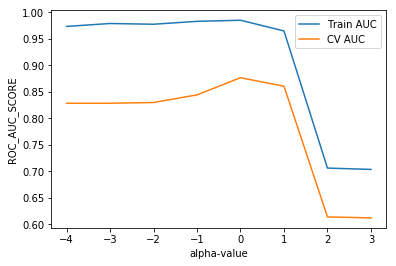

Best alpha Value 1


In [52]:
plt.plot(np.log10(alpha_values), train_auc, label='Train AUC')
plt.plot(np.log10(alpha_values), cv_auc, label='CV AUC')
plt.xlabel('alpha-value')
plt.ylabel('ROC_AUC_SCORE')
plt.legend()
plt.show()  
print("Best alpha Value", c_values[cv_auc.index(max(cv_auc))])

test_auc 0.9004888674474265


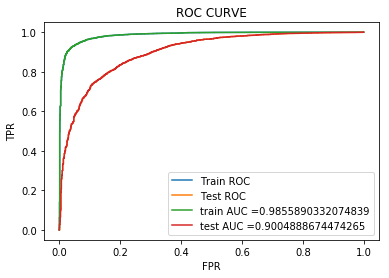

In [53]:
model=SGDClassifier(alpha=c_values[cv_auc.index(max(cv_auc))],loss='hinge')
best_svm=CalibratedClassifierCV(model, cv=2)
best_svm.fit(train_vect, y_tr)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
train_pred = best_svm.predict_proba(train_vect)
train_pred = train_pred[:,1]
#print(np.unique(train_pred))
tr_fpr, tr_tpr, tr_thresh = roc_curve(y_tr, train_pred)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
test_pred = best_svm.predict_proba(test_vect)
test_pred = test_pred[:,1]
#print(np.unique(test_pred))
test_fpr, test_tpr, test_thresh = roc_curve(y_test, test_pred)
auc_tfid_l = auc(test_fpr,test_tpr)
print("test_auc",auc_tfid_l)
plt.plot(tr_fpr, tr_tpr, label="Train ROC")
plt.plot(test_fpr, test_tpr, label="Test ROC")
plt.plot(tr_fpr, tr_tpr, label="train AUC ="+str(auc(tr_fpr, tr_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.legend()
plt.show()

In [54]:
from sklearn.metrics import confusion_matrix
test_pred_class = best_svm.predict(test_vect)
#a = np.unique(test_pred_class)
#print(a)
#print(test_vect.shape)
#print(test_pred_class.shape)
print("Confusion Matrix \n")

C = confusion_matrix(y_test,test_pred_class)
print(C)

accuracy_tfid_l = best_svm.score(test_vect, y_test)
print("Test accuracy : ",accuracy_tfid_l)
#A =((C)/(C.sum(axis=1)))
#B =(C/C.sum(axis=0))

Confusion Matrix 

[[ 347  994]
 [  46 7035]]
Test accuracy :  0.8765138921871289


 Top 10 important features of positive class from<font color='red'> SET 1</font>

In [55]:
# Getting feature names
features = count_vect.get_feature_names()
features.append("review_length")

model=SGDClassifier(alpha=alpha_values[cv_auc.index(max(cv_auc))],loss='hinge')
model.fit(train_vect, y_tr)
#Getting weights of feature names
w_coeff = pd.DataFrame(model.coef_,columns=features)

w_coeff = w_coeff.T

print("Top 10 Positive features \n",w_coeff[0].sort_values(ascending = False)[0:10])

Top 10 Positive features 
 great        0.031040
delicious    0.020088
good         0.019554
remiss       0.018376
best         0.018128
love         0.017418
perfect      0.017310
excellent    0.016791
loves        0.015134
dehydrate    0.014714
Name: 0, dtype: float64


Top 10 important features of negative class from<font color='red'> SET 1</font>

In [56]:


print("Top 10 Negative features \n",w_coeff[0].sort_values(ascending = True)[0:10])

Top 10 Negative features 
 not            -0.045604
disappointed   -0.041079
return         -0.037371
worst          -0.035274
awful          -0.032715
horrible       -0.032706
terrible       -0.031291
threw          -0.028430
ok             -0.027883
refund         -0.027415
Name: 0, dtype: float64


In [57]:
# Please write all the code with proper documentation

### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [58]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation

from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
from scipy import sparse


X_1, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.33, random_state=0)
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.33)


#function to return length of review
def review_len(review):
    reviews_len =[]
    for sent in review:
        reviews_len.append(len(sent.split()))
    return np.array(reviews_len)

print(y_test.value_counts())

w2v_model = w2v_fit(X_tr)
#count_vect = CountVectorizer(ngram_range=(1,2)) 

##--- new feature - Corresponding Review length was added to the test, train and cv vectors seperately
test_vect = avg_w2v_transform(w2v_model,X_test)
#len_arr = review_len(X_test)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
#print(test_vect.shape)
print(test_vect)
#test_vect = sparse.hstack((test_vect,len_arr[:,None])).A

cv_vect = avg_w2v_transform(w2v_model,X_cv)
#len_arr = review_len(X_cv)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
#cv_vect = sparse.hstack((cv_vect,len_arr[:,None])).A

train_vect = avg_w2v_transform(w2v_model,X_tr)
#len_arr = review_len(X_tr)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
#train_vect = sparse.hstack((train_vect,len_arr[:,None])).A

1    7788
0    1476
Name: Score, dtype: int64


  1%|          | 109/9264 [00:00<00:08, 1045.84it/s]

[('good', 0.8649994730949402), ('excellent', 0.8391952514648438), ('amazing', 0.7851092219352722), ('wonderful', 0.7705503106117249), ('fantastic', 0.7256102561950684), ('awesome', 0.7042429447174072), ('theatre', 0.6883372664451599), ('perfect', 0.683326780796051), ('imparts', 0.6744918823242188), ('super', 0.6708419322967529)]
[('hooked', 0.9625660181045532), ('closest', 0.9574567675590515), ('verona', 0.9551575183868408), ('distinctive', 0.9525818228721619), ('world', 0.9504940509796143), ('hotel', 0.9465321898460388), ('pleasure', 0.945990800857544), ('raved', 0.9458307027816772), ('strictly', 0.9454336762428284), ('britt', 0.9452664852142334)]


  2%|▏         | 99/6207 [00:00<00:06, 983.23it/s]

[[ 2.98576707e-02 -5.46216655e-01 -4.82979209e-01 ...  4.71966857e-01
   5.63998993e-01  9.70000000e+01]
 [ 2.98493865e-01 -7.55298491e-01 -6.45507669e-01 ...  7.23631916e-01
   5.32847334e-01  2.10000000e+01]
 [ 6.99961886e-02 -4.37638452e-01 -5.83975350e-01 ... -1.78234176e-01
   5.03147461e-01  5.40000000e+01]
 ...
 [-3.14071737e-02 -4.08637117e-01 -5.56609868e-01 ...  5.32775095e-01
   4.26477777e-01  5.90000000e+01]
 [ 8.83483311e-03 -3.78812176e-01 -6.23163048e-01 ...  8.58556436e-02
   4.03165336e-01  5.20000000e+01]
 [-1.45041257e-03 -4.69038155e-01 -4.85541127e-01 ...  3.03981884e-02
   5.52716698e-01  2.20000000e+01]]


100%|██████████| 12601/12601 [00:11<00:00, 1080.67it/s]


In [59]:
train_auc = []
cv_auc = []
alpha_values = [0.0001,0.001,0.01,0.1,1,10,100,1000]
#K_values = [1].append(K_values)
for i in tqdm(alpha_values):
    #svm = SVC(c=i,kernel='linear')
    model=SGDClassifier(alpha=i,loss='hinge')
    svm=CalibratedClassifierCV(model, cv=2)
    svm.fit(train_vect, y_tr)
    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    cv_pred = svm.predict_proba(cv_vect)
    cv_pred = cv_pred[:,1]
    train_pred = svm.predict_proba(train_vect)
    #train_pred = train_pred[:].max(axis=1)
    train_pred = train_pred[:,1]
    #print(train_pred,"------",cv_pred)
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
    train_auc.append(roc_auc_score(y_tr,train_pred))
    cv_auc.append(roc_auc_score(y_cv,cv_pred))
    

    

100%|██████████| 8/8 [00:00<00:00, 31.16it/s]


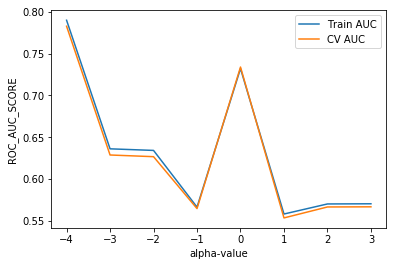

Best alpha-Value 0.0001


In [60]:
plt.plot(np.log10(alpha_values), train_auc, label='Train AUC')
plt.plot(np.log10(alpha_values), cv_auc, label='CV AUC')
plt.xlabel('alpha-value')
plt.ylabel('ROC_AUC_SCORE')
plt.legend()
plt.show()  
print("Best alpha-Value", alpha_values[cv_auc.index(max(cv_auc))])

test_auc 0.6722951577230205


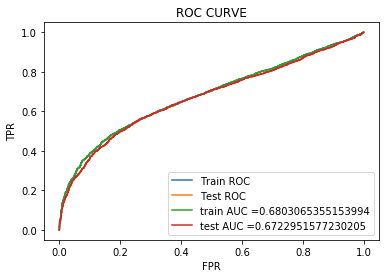

In [61]:
model=SGDClassifier(alpha=c_values[cv_auc.index(max(cv_auc))],loss='hinge')
best_svm=CalibratedClassifierCV(model, cv=2)
best_svm.fit(train_vect, y_tr)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
train_pred = best_svm.predict_proba(train_vect)
train_pred = train_pred[:,1]
#print(np.unique(train_pred))
tr_fpr, tr_tpr, tr_thresh = roc_curve(y_tr, train_pred)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
test_pred = best_svm.predict_proba(test_vect)
test_pred = test_pred[:,1]
#print(np.unique(test_pred))
test_fpr, test_tpr, test_thresh = roc_curve(y_test, test_pred)
auc_w2v_l = auc(test_fpr,test_tpr)
print("test_auc",auc_w2v_l)
plt.plot(tr_fpr, tr_tpr, label="Train ROC")
plt.plot(test_fpr, test_tpr, label="Test ROC")
plt.plot(tr_fpr, tr_tpr, label="train AUC ="+str(auc(tr_fpr, tr_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.legend()
plt.show()

In [62]:
from sklearn.metrics import confusion_matrix
test_pred_class = best_svm.predict(test_vect)
#a = np.unique(test_pred_class)
#print(a)
#print(test_vect.shape)
#print(test_pred_class.shape)
print("Confusion Matrix \n")

C = confusion_matrix(y_test,test_pred_class)
print(C)

accuracy_w2v_l = best_svm.score(test_vect, y_test)
print("Test accuracy : ",accuracy_w2v_l)
#A =((C)/(C.sum(axis=1)))
#B =(C/C.sum(axis=0))

Confusion Matrix 

[[   1 1475]
 [   4 7784]]
Test accuracy :  0.8403497409326425


### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [63]:
# Please write all the code with proper documentation

from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
from scipy import sparse


X_1, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.33, random_state=0)
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.33)


#function to return length of review
def review_len(review):
    reviews_len =[]
    for sent in review:
        reviews_len.append(len(sent.split()))
    return np.array(reviews_len)

print(y_test.value_counts())

model = TfidfVectorizer()
model.fit(X_tr)
w2v_model = w2v_fit(X_tr)

#count_vect = CountVectorizer(ngram_range=(1,2)) 

##--- new feature - Corresponding Review length was added to the test, train and cv vectors seperately
test_vect = tf_idf_transform(model,w2v_model,X_test)
#len_arr = review_len(X_test)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
#test_vect = sparse.hstack((test_vect,len_arr[:,None])).A

cv_vect = tf_idf_transform(model,w2v_model,X_cv)
#len_arr = review_len(X_cv)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
#cv_vect = sparse.hstack((cv_vect,len_arr[:,None])).A

train_vect = tf_idf_transform(model,w2v_model,X_tr)
#len_arr = review_len(X_tr)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
#train_vect = sparse.hstack((train_vect,len_arr[:,None])).A

1    7788
0    1476
Name: Score, dtype: int64


  0%|          | 0/9264 [00:00<?, ?it/s]

[('good', 0.8448598980903625), ('excellent', 0.7664974331855774), ('wonderful', 0.7469795942306519), ('awesome', 0.7186698317527771), ('amazing', 0.7111882567405701), ('fantastic', 0.6916230320930481), ('super', 0.6884647011756897), ('delicious', 0.6826521158218384), ('love', 0.6739854216575623), ('quick', 0.6439713835716248)]
[('world', 0.9611328840255737), ('decades', 0.9576990604400635), ('exciting', 0.9575232863426208), ('closest', 0.9533124566078186), ('variation', 0.9516345858573914), ('admit', 0.9450585842132568), ('reviewed', 0.9429587125778198), ('hooked', 0.9412384033203125), ('dissapointed', 0.9411522150039673), ('absolute', 0.9397194385528564)]


100%|██████████| 12601/12601 [01:12<00:00, 174.87it/s]


In [64]:
train_auc = []
cv_auc = []
alpha_values = [0.0001,0.001,0.01,0.1,1,10,100,1000]
#K_values = [1].append(K_values)
for i in tqdm(alpha_values):
    #svm = SVC(c=i,kernel='linear')
    model=SGDClassifier(alpha=i,loss='hinge')
    svm=CalibratedClassifierCV(model, cv=2)
    svm.fit(train_vect, y_tr)
    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    cv_pred = svm.predict_proba(cv_vect)
    cv_pred = cv_pred[:,1]
    train_pred = svm.predict_proba(train_vect)
    #train_pred = train_pred[:].max(axis=1)
    train_pred = train_pred[:,1]
    #print(train_pred,"------",cv_pred)
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
    train_auc.append(roc_auc_score(y_tr,train_pred))
    cv_auc.append(roc_auc_score(y_cv,cv_pred))
    

    

100%|██████████| 8/8 [00:00<00:00, 25.54it/s]


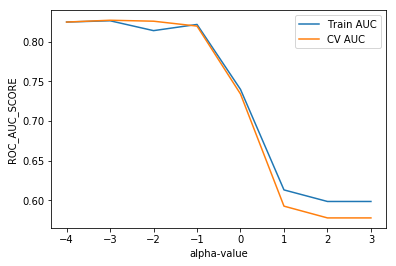

Best alpha-Value 0.001


In [65]:
plt.plot(np.log10(alpha_values), train_auc, label='Train AUC')
plt.plot(np.log10(alpha_values), cv_auc, label='CV AUC')
plt.xlabel('alpha-value')
plt.ylabel('ROC_AUC_SCORE')
plt.legend()
plt.show()  
print("Best alpha-Value", alpha_values[cv_auc.index(max(cv_auc))])

test_auc 0.8053144090762943


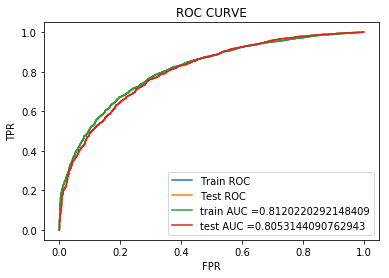

In [66]:
model=SGDClassifier(alpha=c_values[cv_auc.index(max(cv_auc))],loss='hinge')
best_svm=CalibratedClassifierCV(model, cv=2)
best_svm.fit(train_vect, y_tr)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
train_pred = best_svm.predict_proba(train_vect)
train_pred = train_pred[:,1]
#print(np.unique(train_pred))
tr_fpr, tr_tpr, tr_thresh = roc_curve(y_tr, train_pred)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
test_pred = best_svm.predict_proba(test_vect)
test_pred = test_pred[:,1]
#print(np.unique(test_pred))
test_fpr, test_tpr, test_thresh = roc_curve(y_test, test_pred)
auc_tfid_w2v_l = auc(test_fpr,test_tpr)
print("test_auc",auc_tfid_w2v_l)
plt.plot(tr_fpr, tr_tpr, label="Train ROC")
plt.plot(test_fpr, test_tpr, label="Test ROC")
plt.plot(tr_fpr, tr_tpr, label="train AUC ="+str(auc(tr_fpr, tr_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.legend()
plt.show()

In [67]:
from sklearn.metrics import confusion_matrix
test_pred_class = best_svm.predict(test_vect)
#a = np.unique(test_pred_class)
#print(a)
#print(test_vect.shape)
#print(test_pred_class.shape)
print("Confusion Matrix \n")

C = confusion_matrix(y_test,test_pred_class)
print(C)

accuracy_tfid_w2v_l = best_svm.score(test_vect, y_test)
print("Test accuracy : ",accuracy_tfid_w2v_l)
#A =((C)/(C.sum(axis=1)))
#B =(C/C.sum(axis=0))

Confusion Matrix 

[[ 238 1238]
 [ 110 7678]]
Test accuracy :  0.8544905008635578


In [68]:
# Please write all the code with proper documentation

## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [69]:
# Please write all the code with proper documentation
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation

X_1, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)


print(y_test.value_counts())

count_vect = CountVectorizer(min_df=10,max_features=500) 
count_vect.fit(X_tr)
test_vect = count_vect.transform(X_test)
cv_vect = count_vect.transform(X_cv)
train_vect = count_vect.transform(X_tr)


len_arr = review_len(X_test)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
test_vect = sparse.hstack((test_vect,len_arr[:,None])).A

len_arr = review_len(X_tr)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
train_vect = sparse.hstack((train_vect,len_arr[:,None])).A

len_arr = review_len(X_cv)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
cv_vect = sparse.hstack((cv_vect,len_arr[:,None])).A

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
scaler.fit(test_vect)  
train_vect = scaler.transform(train_vect)
test_vect = scaler.transform(test_vect)
cv_vect = scaler.transform(cv_vect)


print("After vectorizations")
print(train_vect.shape, y_tr.shape)
print(cv_vect.shape, y_cv.shape)
print(test_vect.shape, y_test.shape)
print("="*100)

1    7081
0    1341
Name: Score, dtype: int64
After vectorizations
(13755, 501) (13755,)
(5895, 501) (5895,)
(8422, 501) (8422,)


/Users/ravishankar/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ravishankar/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ravishankar/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ravishankar/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [70]:
train_auc = []
cv_auc = []
alpha_values = [0.0001,0.001,0.01,0.1,1,10,100,1000]
#K_values = [1].append(K_values)
for i in tqdm(alpha_values):
    svm = SVC(C=i,kernel='rbf',probability=True)
    svm.fit(train_vect, y_tr)
    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    cv_pred = svm.predict_proba(cv_vect)
    cv_pred = cv_pred[:,1]
    train_pred = svm.predict_proba(train_vect)
    #train_pred = train_pred[:].max(axis=1)
    train_pred = train_pred[:,1]
    #print(train_pred,"------",cv_pred)
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
    train_auc.append(roc_auc_score(y_tr,train_pred))
    cv_auc.append(roc_auc_score(y_cv,cv_pred))
    

    

100%|██████████| 8/8 [53:00<00:00, 450.72s/it]


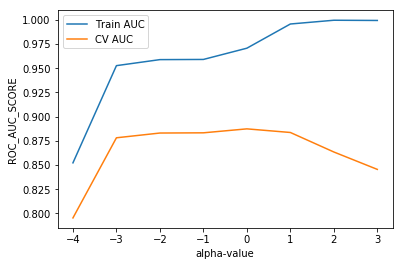

Best c-Value 1


In [71]:
plt.plot(np.log10(alpha_values), train_auc, label='Train AUC')
plt.plot(np.log10(alpha_values), cv_auc, label='CV AUC')
plt.xlabel('alpha-value')
plt.ylabel('ROC_AUC_SCORE')
plt.legend()
plt.show()  
print("Best c-Value", alpha_values[cv_auc.index(max(cv_auc))])

test_auc 0.8864454468012151


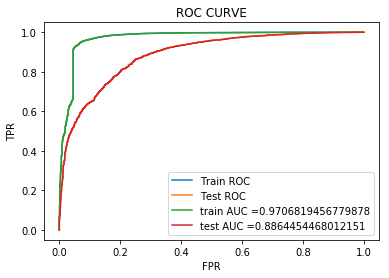

In [72]:
best_svm = SVC(C=alpha_values[cv_auc.index(max(cv_auc))],kernel='rbf',probability=True)
best_svm.fit(train_vect, y_tr)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
train_pred = best_svm.predict_proba(train_vect)
train_pred = train_pred[:,1]
#print(np.unique(train_pred))
tr_fpr, tr_tpr, tr_thresh = roc_curve(y_tr, train_pred)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
test_pred = best_svm.predict_proba(test_vect)
test_pred = test_pred[:,1]
#print(np.unique(test_pred))
test_fpr, test_tpr, test_thresh = roc_curve(y_test, test_pred)
auc_bow_r = auc(test_fpr,test_tpr)
print("test_auc",auc_bow_r)
plt.plot(tr_fpr, tr_tpr, label="Train ROC")
plt.plot(test_fpr, test_tpr, label="Test ROC")
plt.plot(tr_fpr, tr_tpr, label="train AUC ="+str(auc(tr_fpr, tr_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.legend()
plt.show()

In [73]:
from sklearn.metrics import confusion_matrix
test_pred_class = best_svm.predict(test_vect)
#a = np.unique(test_pred_class)
#print(a)
#print(test_vect.shape)
#print(test_pred_class.shape)
print("Confusion Matrix \n")

C = confusion_matrix(y_test,test_pred_class)
print(C)

accuracy_bow_r = best_svm.score(test_vect, y_test)
print("Test accuracy : ",accuracy_bow_r)
#A =((C)/(C.sum(axis=1)))
#B =(C/C.sum(axis=0))

Confusion Matrix 

[[ 407  934]
 [  97 6984]]
Test accuracy :  0.8775825219662788


In [74]:
# Please write all the code with proper documentation

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [75]:
# Please write all the code with proper documentation
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation

X_1, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)


print(y_test.value_counts())

count_vect = TfidfVectorizer(min_df=10,max_features=500)
count_vect.fit(X_tr)
test_vect = count_vect.transform(X_test)
cv_vect = count_vect.transform(X_cv)
train_vect = count_vect.transform(X_tr)


len_arr = review_len(X_test)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
test_vect = sparse.hstack((test_vect,len_arr[:,None])).A

len_arr = review_len(X_tr)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
train_vect = sparse.hstack((train_vect,len_arr[:,None])).A

len_arr = review_len(X_cv)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
cv_vect = sparse.hstack((cv_vect,len_arr[:,None])).A

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
scaler.fit(test_vect)  
train_vect = scaler.transform(train_vect)
test_vect = scaler.transform(test_vect)
cv_vect = scaler.transform(cv_vect)


print("After vectorizations")
print(train_vect.shape, y_tr.shape)
print(cv_vect.shape, y_cv.shape)
print(test_vect.shape, y_test.shape)
print("="*100)

1    7081
0    1341
Name: Score, dtype: int64
After vectorizations
(13755, 501) (13755,)
(5895, 501) (5895,)
(8422, 501) (8422,)


In [76]:
train_auc = []
cv_auc = []
alpha_values = [0.0001,0.001,0.01,0.1,1,10,100,1000]
#K_values = [1].append(K_values)
for i in tqdm(alpha_values):
    svm = SVC(C=i,kernel='rbf',probability=True)
    svm.fit(train_vect, y_tr)
    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    cv_pred = svm.predict_proba(cv_vect)
    cv_pred = cv_pred[:,1]
    train_pred = svm.predict_proba(train_vect)
    #train_pred = train_pred[:].max(axis=1)
    train_pred = train_pred[:,1]
    #print(train_pred,"------",cv_pred)
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
    train_auc.append(roc_auc_score(y_tr,train_pred))
    cv_auc.append(roc_auc_score(y_cv,cv_pred))
    

    

100%|██████████| 8/8 [1:10:31<00:00, 689.55s/it]


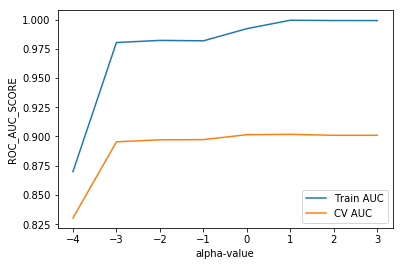

Best c-Value 10


In [77]:
plt.plot(np.log10(alpha_values), train_auc, label='Train AUC')
plt.plot(np.log10(alpha_values), cv_auc, label='CV AUC')
plt.xlabel('alpha-value')
plt.ylabel('ROC_AUC_SCORE')
plt.legend()
plt.show()  
print("Best c-Value", alpha_values[cv_auc.index(max(cv_auc))])

test_auc 0.898167060374461


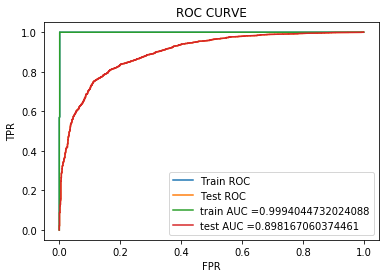

In [78]:
best_svm = SVC(C=alpha_values[cv_auc.index(max(cv_auc))],kernel='rbf',probability=True)
best_svm.fit(train_vect, y_tr)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
train_pred = best_svm.predict_proba(train_vect)
train_pred = train_pred[:,1]
#print(np.unique(train_pred))
tr_fpr, tr_tpr, tr_thresh = roc_curve(y_tr, train_pred)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
test_pred = best_svm.predict_proba(test_vect)
test_pred = test_pred[:,1]
#print(np.unique(test_pred))
test_fpr, test_tpr, test_thresh = roc_curve(y_test, test_pred)
auc_tfid_r = auc(test_fpr,test_tpr)
print("test_auc",auc_tfid_r)
plt.plot(tr_fpr, tr_tpr, label="Train ROC")
plt.plot(test_fpr, test_tpr, label="Test ROC")
plt.plot(tr_fpr, tr_tpr, label="train AUC ="+str(auc(tr_fpr, tr_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.legend()
plt.show()

In [79]:
from sklearn.metrics import confusion_matrix
test_pred_class = best_svm.predict(test_vect)
#a = np.unique(test_pred_class)
#print(a)
#print(test_vect.shape)
#print(test_pred_class.shape)
print("Confusion Matrix \n")

C = confusion_matrix(y_test,test_pred_class)
print(C)

accuracy_tfid_r = best_svm.score(test_vect, y_test)
print("Test accuracy : ",accuracy_tfid_r)
#A =((C)/(C.sum(axis=1)))
#B =(C/C.sum(axis=0))

Confusion Matrix 

[[ 596  745]
 [ 187 6894]]
Test accuracy :  0.8893374495369271


In [80]:
# Please write all the code with proper documentation

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [81]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation

from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
from scipy import sparse


X_1, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.33, random_state=0)
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.33)


#function to return length of review
def review_len(review):
    reviews_len =[]
    for sent in review:
        reviews_len.append(len(sent.split()))
    return np.array(reviews_len)

print(y_test.value_counts())

w2v_model = w2v_fit(X_tr)
#count_vect = CountVectorizer(ngram_range=(1,2)) 

##--- new feature - Corresponding Review length was added to the test, train and cv vectors seperately
test_vect = avg_w2v_transform(w2v_model,X_test)
#len_arr = review_len(X_test)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
#print(test_vect.shape)
print(test_vect)
#test_vect = sparse.hstack((test_vect,len_arr[:,None])).A

cv_vect = avg_w2v_transform(w2v_model,X_cv)
#len_arr = review_len(X_cv)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
#cv_vect = sparse.hstack((cv_vect,len_arr[:,None])).A

train_vect = avg_w2v_transform(w2v_model,X_tr)
#len_arr = review_len(X_tr)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
#train_vect = sparse.hstack((train_vect,len_arr[:,None])).A

1    7788
0    1476
Name: Score, dtype: int64


  1%|          | 108/9264 [00:00<00:08, 1074.45it/s]

[('good', 0.7974837422370911), ('excellent', 0.7871569395065308), ('fantastic', 0.7369920015335083), ('amazing', 0.7156749367713928), ('well', 0.7148282527923584), ('wonderful', 0.7113310098648071), ('awesome', 0.7110161781311035), ('makes', 0.6921865940093994), ('decent', 0.6718159914016724), ('especially', 0.6652876138687134)]
[('world', 0.9577041864395142), ('hooked', 0.948095977306366), ('kinds', 0.9436710476875305), ('tahini', 0.9416037797927856), ('varieties', 0.9415442943572998), ('planet', 0.9412354230880737), ('jamaica', 0.9404845237731934), ('superior', 0.9403778910636902), ('restaurants', 0.9388030767440796), ('absolute', 0.9384139180183411)]


  2%|▏         | 104/6207 [00:00<00:05, 1034.62it/s]

[[ 5.56352953e-02 -5.15511155e-01 -3.57781923e-01 ...  3.31214119e-01
   4.17190636e-01  9.60000000e+01]
 [ 3.29639638e-01 -6.28054107e-01 -4.83599474e-01 ...  5.84086890e-01
   4.57614251e-01  2.10000000e+01]
 [ 1.00038805e-01 -3.02819702e-01 -4.38342150e-01 ... -2.89670166e-01
   5.83421967e-01  5.40000000e+01]
 ...
 [ 9.06413007e-02 -3.82312768e-01 -5.43051206e-01 ...  5.44356287e-01
   3.77976663e-01  5.70000000e+01]
 [ 4.80382589e-02 -3.24454343e-01 -5.37434177e-01 ... -1.32469446e-02
   4.02964009e-01  5.20000000e+01]
 [ 6.41436020e-02 -3.75130798e-01 -3.37311718e-01 ... -4.10896959e-02
   5.83517728e-01  2.20000000e+01]]


100%|██████████| 12601/12601 [00:09<00:00, 1261.38it/s]


In [82]:
train_auc = []
cv_auc = []
alpha_values = [0.0001,0.001,0.01,0.1,1,10,100,1000]
#K_values = [1].append(K_values)
for i in tqdm(alpha_values):
    svm = SVC(C=i,kernel='rbf',probability=True)
    svm.fit(train_vect, y_tr)
    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    cv_pred = svm.predict_proba(cv_vect)
    cv_pred = cv_pred[:,1]
    train_pred = svm.predict_proba(train_vect)
    #train_pred = train_pred[:].max(axis=1)
    train_pred = train_pred[:,1]
    #print(train_pred,"------",cv_pred)
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
    train_auc.append(roc_auc_score(y_tr,train_pred))
    cv_auc.append(roc_auc_score(y_cv,cv_pred))
    

    

100%|██████████| 8/8 [04:52<00:00, 49.64s/it]


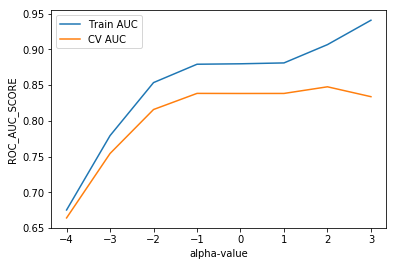

Best c-Value 100


In [83]:
plt.plot(np.log10(alpha_values), train_auc, label='Train AUC')
plt.plot(np.log10(alpha_values), cv_auc, label='CV AUC')
plt.xlabel('alpha-value')
plt.ylabel('ROC_AUC_SCORE')
plt.legend()
plt.show()  
print("Best c-Value", alpha_values[cv_auc.index(max(cv_auc))])

test_auc 0.8409247062745409


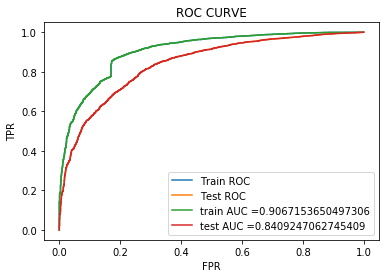

In [84]:
best_svm = SVC(C=alpha_values[cv_auc.index(max(cv_auc))],kernel='rbf',probability=True)
best_svm.fit(train_vect, y_tr)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
train_pred = best_svm.predict_proba(train_vect)
train_pred = train_pred[:,1]
#print(np.unique(train_pred))
tr_fpr, tr_tpr, tr_thresh = roc_curve(y_tr, train_pred)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
test_pred = best_svm.predict_proba(test_vect)
test_pred = test_pred[:,1]
#print(np.unique(test_pred))
test_fpr, test_tpr, test_thresh = roc_curve(y_test, test_pred)
auc_w2v_r = auc(test_fpr,test_tpr)
print("test_auc",auc_w2v_r)
plt.plot(tr_fpr, tr_tpr, label="Train ROC")
plt.plot(test_fpr, test_tpr, label="Test ROC")
plt.plot(tr_fpr, tr_tpr, label="train AUC ="+str(auc(tr_fpr, tr_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.legend()
plt.show()

In [85]:
from sklearn.metrics import confusion_matrix
test_pred_class = best_svm.predict(test_vect)
#a = np.unique(test_pred_class)
#print(a)
#print(test_vect.shape)
#print(test_pred_class.shape)
print("Confusion Matrix \n")

C = confusion_matrix(y_test,test_pred_class)
print(C)

accuracy_w2v_r = best_svm.score(test_vect, y_test)
print("Test accuracy : ",accuracy_w2v_r)
#A =((C)/(C.sum(axis=1)))
#B =(C/C.sum(axis=0))

Confusion Matrix 

[[ 365 1111]
 [ 212 7576]]
Test accuracy :  0.8571891191709845


In [86]:
# Please write all the code with proper documentation

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [87]:
# Please write all the code with proper documentation

from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
from scipy import sparse


X_1, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.33, random_state=0)
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.33)


#function to return length of review
def review_len(review):
    reviews_len =[]
    for sent in review:
        reviews_len.append(len(sent.split()))
    return np.array(reviews_len)

print(y_test.value_counts())

model = TfidfVectorizer()
model.fit(X_tr)
w2v_model = w2v_fit(X_tr)

#count_vect = CountVectorizer(ngram_range=(1,2)) 

##--- new feature - Corresponding Review length was added to the test, train and cv vectors seperately
test_vect = tf_idf_transform(model,w2v_model,X_test)
#len_arr = review_len(X_test)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
#test_vect = sparse.hstack((test_vect,len_arr[:,None])).A

cv_vect = tf_idf_transform(model,w2v_model,X_cv)
#len_arr = review_len(X_cv)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
#cv_vect = sparse.hstack((cv_vect,len_arr[:,None])).A

train_vect = tf_idf_transform(model,w2v_model,X_tr)
#len_arr = review_len(X_tr)
#https://stackoverflow.com/questions/41937786/add-column-to-a-sparse-matrix
#train_vect = sparse.hstack((train_vect,len_arr[:,None])).A

1    7788
0    1476
Name: Score, dtype: int64


  0%|          | 15/9264 [00:00<01:09, 133.80it/s]

[('excellent', 0.8071097135543823), ('good', 0.802000105381012), ('awesome', 0.7496376037597656), ('wonderful', 0.7250949740409851), ('fantastic', 0.7055032253265381), ('amazing', 0.6993367671966553), ('theatre', 0.6801465749740601), ('super', 0.6787183284759521), ('makes', 0.6695502400398254), ('theater', 0.6674681305885315)]
[('hooked', 0.968199610710144), ('world', 0.9625104069709778), ('writes', 0.9496701955795288), ('closest', 0.9452397227287292), ('british', 0.9422691464424133), ('ka', 0.9391700625419617), ('wife', 0.9387003183364868), ('absolute', 0.9384856820106506), ('pleasure', 0.9380527138710022), ('visiting', 0.9376016855239868)]


100%|██████████| 12601/12601 [01:17<00:00, 163.10it/s]


In [88]:
train_auc = []
cv_auc = []
alpha_values = [0.0001,0.001,0.01,0.1,1,10,100,1000]
#K_values = [1].append(K_values)
for i in tqdm(alpha_values):
    svm = SVC(C=i,kernel='rbf',probability=True)
    svm.fit(train_vect, y_tr)
    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    cv_pred = svm.predict_proba(cv_vect)
    cv_pred = cv_pred[:,1]
    train_pred = svm.predict_proba(train_vect)
    #train_pred = train_pred[:].max(axis=1)
    train_pred = train_pred[:,1]
    #print(train_pred,"------",cv_pred)
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
    train_auc.append(roc_auc_score(y_tr,train_pred))
    cv_auc.append(roc_auc_score(y_cv,cv_pred))
    

    

100%|██████████| 8/8 [04:27<00:00, 40.86s/it]


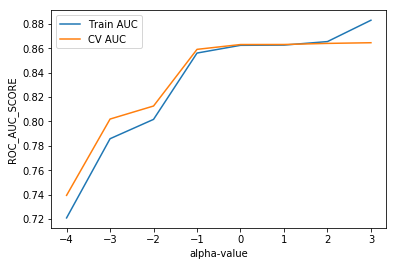

Best c-Value 1000


In [89]:
plt.plot(np.log10(alpha_values), train_auc, label='Train AUC')
plt.plot(np.log10(alpha_values), cv_auc, label='CV AUC')
plt.xlabel('alpha-value')
plt.ylabel('ROC_AUC_SCORE')
plt.legend()
plt.show()  
print("Best c-Value", alpha_values[cv_auc.index(max(cv_auc))])

test_auc 0.8496673535687591


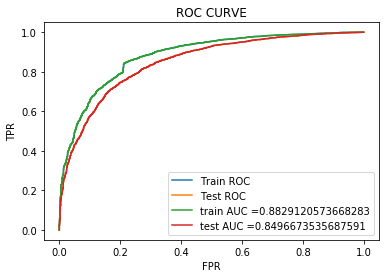

In [90]:
best_svm = SVC(C=alpha_values[cv_auc.index(max(cv_auc))],kernel='rbf',probability=True)
best_svm.fit(train_vect, y_tr)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
train_pred = best_svm.predict_proba(train_vect)
train_pred = train_pred[:,1]
#print(np.unique(train_pred))
tr_fpr, tr_tpr, tr_thresh = roc_curve(y_tr, train_pred)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
test_pred = best_svm.predict_proba(test_vect)
test_pred = test_pred[:,1]
#print(np.unique(test_pred))
test_fpr, test_tpr, test_thresh = roc_curve(y_test, test_pred)
auc_tfid_w2v_r = auc(test_fpr,test_tpr)
print("test_auc",auc_tfid_w2v_r)
plt.plot(tr_fpr, tr_tpr, label="Train ROC")
plt.plot(test_fpr, test_tpr, label="Test ROC")
plt.plot(tr_fpr, tr_tpr, label="train AUC ="+str(auc(tr_fpr, tr_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.legend()
plt.show()

In [91]:
from sklearn.metrics import confusion_matrix
test_pred_class = best_svm.predict(test_vect)
#a = np.unique(test_pred_class)
#print(a)
#print(test_vect.shape)
#print(test_pred_class.shape)
print("Confusion Matrix \n")

C = confusion_matrix(y_test,test_pred_class)
print(C)

accuracy_tfid_w2v_r = best_svm.score(test_vect, y_test)
print("Test accuracy : ",accuracy_tfid_w2v_r)
#A =((C)/(C.sum(axis=1)))
#B =(C/C.sum(axis=0))

Confusion Matrix 

[[ 291 1185]
 [ 115 7673]]
Test accuracy :  0.8596718480138169


# [6] Conclusions

In [95]:
# Please compare all your models using Prettytable library

# Please compare all your models using Prettytable library

from prettytable import PrettyTable

## Prettytable reference: http://zetcode.com/python/prettytable/
x = PrettyTable(["Model", "Vectoriser", "alpha value","Accuracy", "AUC"])

x.add_row(["Linear SVM","BOW",1,accuracy_bow_l*100, auc_bow_l])
x.add_row(["Linear SVM","TFIDF",1, accuracy_tfid_l*100, auc_tfid_l])
x.add_row(["Linear SVM","AVGW2V",0.001, accuracy_w2v_l*100, auc_w2v_l])
x.add_row(["Linear SVM","TFIDF_W2V",0.001, accuracy_tfid_w2v_l*100, auc_tfid_w2v_l])
x.add_row(["RBF SVM","BOW",1,accuracy_bow_l*100, auc_bow_r])
x.add_row(["RBF SVM","TFIDF",10,accuracy_tfid_l*100, auc_tfid_r])
x.add_row(["RBF SVM","AVGW2V",100,accuracy_w2v_l*100, auc_w2v_r])
x.add_row(["RBF SVM","TFIDF_W2V",1000, accuracy_tfid_w2v_l*100, auc_tfid_w2v_r])

print(x.get_string())

+------------+------------+-------------+-------------------+--------------------+
|   Model    | Vectoriser | alpha value |      Accuracy     |        AUC         |
+------------+------------+-------------+-------------------+--------------------+
| Linear SVM |    BOW     |      1      | 87.85324151033008 | 0.9030482577179524 |
| Linear SVM |   TFIDF    |      1      |  87.6513892187129 | 0.9004888674474265 |
| Linear SVM |   AVGW2V   |    0.001    | 84.03497409326425 | 0.6722951577230205 |
| Linear SVM | TFIDF_W2V  |    0.001    | 85.44905008635578 | 0.8053144090762943 |
|  RBF SVM   |    BOW     |      1      | 87.85324151033008 | 0.8864454468012151 |
|  RBF SVM   |   TFIDF    |      10     |  87.6513892187129 | 0.898167060374461  |
|  RBF SVM   |   AVGW2V   |     100     | 84.03497409326425 | 0.8409247062745409 |
|  RBF SVM   | TFIDF_W2V  |     1000    | 85.44905008635578 | 0.8496673535687591 |
+------------+------------+-------------+-------------------+--------------------+


Summary :

Amazon food review classification was done with SVM classifier with BOW,TFIDF,AVGW2V and TFIDFW2V vectorizers.

1. Text preprocessing was done on the reviews column of the dataset.
2. Also new feature - Review length was added and analyzed.
4. For RBFSVM, the min_df was set to 5 thereby discarding all the words with frequency lessthan 5, also the max features was set to 500.
5. The top 10 important features of positive and negative classes were found for BOW and TFIDF vectorizers.
6. The accuracies of the model in different cases were tabulated. 